In [95]:
run "/Users/octavia/Dropbox/fire/fire_model/startup.py"

In [96]:
# Simulation batch

def wrap_read_sims(case):
    
    sim_dir = os.path.join(project_dir, "model_output", case)
    file_dir = os.path.join(sim_dir, "all_sims")
    if os.path.isdir(file_dir)  == False:
        os.mkdir(file_dir)

    sys.path.append(sim_dir)
    if "params" in sys.modules:
        del sys.modules["params"]
        
    from params import all_params
    
    batch_pklz = [f for f in os.listdir(sim_dir) if ".pkl" in f]
    res = pd.DataFrame()
    for f in batch_pklz:
        batch = load_object(sim_dir + '/' + f)
        res = res.append(batch, ignore_index = True)
        
    res["mean_phi_S"] = [np.array(d).mean() for d in res.severity_list]
    res["fire_count"] = [len(np.array(d)) for d in res.severity_list]

    return res, all_params

In [97]:
res, params = wrap_read_sims("v_frequent_fire_large_kl")

In [98]:
res_v, params_v = wrap_read_sims("v_supress_fire_large_kl")

In [99]:
# PLOT CODE
# all_sims = read_all_sims(file_dir)
# fig, ax = plt.subplots(1, figsize = (14,4) )

# for key, p in enumerate(all_sims[:100]):

#     line_u = ax.plot(p.t_p, 
#         p.G_u_list, 'b--', lw = 1, 
#         label ="upper canopy")       
#     line_l = ax.plot(p.t_p, 
#         p.G_l_list, 'g--', lw = 1, 
#         label ="upper canopy")          
    

In [123]:
def classify_landcover(results):
    """
    Reclassify vegetatino type by G_l, G_u, k_l and k_u
    """    
    # tree favoring
    # query_string = "((G_u > 2*k_l)) | (G_u < k_l) & (G_l < G_u)"
    query_string = "(G_u > 3*G_l)"
    # shrub favoring
    # query_string = "(G_u > k_l) "    
    results["tree_final"] = 0
    results.loc[ results.query(query_string).index, "tree_final"] = 1
    
    results["shrub_final"] = 0
    # tree favoring
    query_string = "(G_u < 3*G_l)"
    results.loc[results.query(query_string).index, "shrub_final"] = 1
    # shrub favoring
    # results.loc[results.query("(G_u < k_l)").index, "shrub_final"] = 1

    excess_shrubs = "(G_l >  k_l/(k_u-k_l)*(-G_u + k_u + 20))"
    results["bad"] = 0
    results.loc[results.query(excess_shrubs).index, "bad"] = 1
    
    results["tree_init"] = results["G_uo"] > results["G_lo"]
    results["shrub_init"] = results["G_uo"] < results["G_lo"]


    results["tree_to_shrub"] =  ~ results["tree_final"] & results['tree_init']
    results["tree_to_tree"] = results["tree_final"] & results['tree_init']
    results["shrub_to_tree"] = results["tree_final"] & ~results['tree_init']
    results["shrub_to_shrub"] = ~results["tree_final"] & ~results['tree_init']
    return results


In [124]:
res = classify_landcover(res)

In [125]:
res_v = classify_landcover(res_v)

Text(0, 0.5, 'G_l')

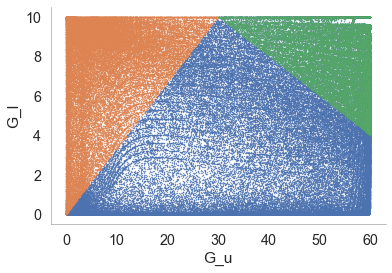

In [126]:
subset = res[(res["tree_final"] ==1) ]
plt.scatter(subset.G_u, subset.G_l, s= .1)
subset = res[(res["shrub_final"] == 1) ]
plt.scatter(subset.G_u, subset.G_l, s = .1)
subset = res[(res["bad"])==1 ]
plt.scatter(subset.G_u, subset.G_l, s = .1,label= "excess shrub")
plt.xlabel("G_u")
plt.ylabel("G_l")


In [127]:
batch_names = np.unique(res["batch_name"])
tabs = pd.DataFrame()

for i, batch_name in enumerate(batch_names):
    subset = res[res.batch_name == batch_name].sample(500)

In [214]:
def compute_summary (res):
    """
    Compute transition errors
    """
    batch_names = np.unique(res["batch_name"])
    tabs = pd.DataFrame()

    for i, batch_name in enumerate(batch_names):
        subset = res[res.batch_name == batch_name].sample(500)

        tabs = tabs.append(
            {"tree_final" : subset["tree_final"].mean(),
             "tree_init" : subset["tree_init"].mean(),
             "shrub_to_tree" : subset["shrub_to_tree"].mean(),
             "tree_to_shrub" : subset["tree_to_shrub"].mean(),
             "tree_to_tree" : subset["tree_to_tree"].mean(),         
             'alpha' : subset['alpha'].mean(),
             'beta' : subset['beta'].mean(),
             "g_l" : subset["g_l"].mean(),
             "g_u" : subset["g_u"].mean(),
             "g_l_std" : subset["g_l"].std(),        
             "g_u_std" : subset["g_u"].std(),       
             "G_u" : subset["G_u"].mean(), 
             "G_u_mean_c" : subset["G_u_mean_c"].mean(),
             "G_l" : subset["G_l"].mean(),
             "bad" : subset["bad"].sum()/subset.shape[0],
             "k_l" : subset["k_l"].mean(),             
             "k_u" : subset["k_u"].mean(),      
             "r_l" : subset["r_l"].mean(),             
             "r_u" : subset["r_u"].mean(),
             "beta" : subset["beta"].mean(),             
             "alpha" : subset["alpha"].mean(),
             "RI" : subset["RI"].mean(),             
             "severity" : subset["severity"].mean(),
             "mean_phi_S" : subset["mean_phi_S"].mean(),
             "no_fire":  subset["mean_phi_S"].isnull().mean(),
             "fire_count":  subset["fire_count"].mean(),
             "S" :  subset["S"].mean()
            }     
            , ignore_index = 1)

    tabs.index =batch_names




    return tabs

In [216]:
def compute_error(tabs):
    tabs['tree_final_error'] = (tabs['tree_final'] -  0.6279)*100
    tabs['shrub_to_tree_err'] = (tabs['shrub_to_tree'] - 0.06419)*100
    tabs['tree_to_shrub_err'] = (tabs['tree_to_shrub'] -  0.254)*100
    return tabs

def compute_v_error(tabs):
    tabs['tree_final_error'] = (tabs['tree_final'] -  0.833)*100
    tabs['shrub_to_tree_err'] = (tabs['shrub_to_tree'] - 0.254)*100
    tabs['tree_to_shrub_err'] = (tabs['tree_to_shrub'] -  0.06419)*100
    return tabs

In [217]:
tabs = compute_summary(res)
tabs = compute_error(tabs)
tabs_v = compute_summary(res_v)
tabs_v = compute_v_error(tabs_v)
# tabs = tabs[tabs.bad<0.5]
# tabs_v = tabs_v[tabs_v.bad<0.5]

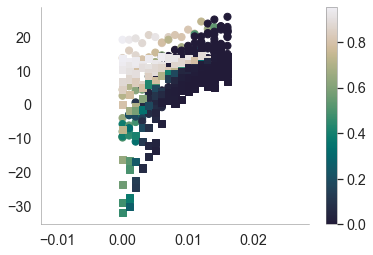

In [218]:
plt.scatter(tabs.alpha, tabs.tree_final_error, s = 50, c = tabs.bad, cmap = "cmo.rain_r")
plt.scatter(tabs_v.alpha, tabs_v.tree_final_error, s = 50, marker = 's', c = tabs_v.bad, cmap = "cmo.rain_r")
# plt.ylim(-5, 5)
plt.colorbar()

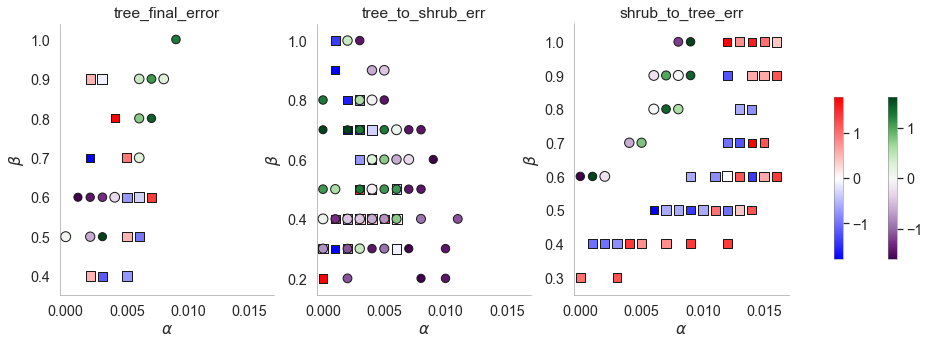

In [285]:



maxerr = 2
def ab_error_plot(ax, metric, maxerr, cbar = 0):

    sub = tabs.query("(abs({0}) < {1})".format(metric, maxerr) )
    sub_v = tabs_v.query("(abs({0}) < {1})".format(metric, maxerr) )

    scale = 1
    sizes = (10 - np.abs(sub[metric]))
    t1 = ax.scatter(sub.alpha**scale, sub.beta, marker = "s", 
                c = sub[metric], 
                s = sizes**2,  cmap = "bwr", edgecolor = "k")


    valid_sizes = (10 - np.abs(sub_v[metric]))

    t2 = ax.scatter(sub_v.alpha**scale, sub_v.beta, marker = "o", 
                c = sub_v[metric], 
                s = valid_sizes**2,  cmap = "PRGn", edgecolor = "k")

    if cbar:
        fig.subplots_adjust(right=0.8)
        
        cbar_ax = fig.add_axes([0.8, 0.1, 0.05, 0.7])
        cbar_ax.axis('off')
        
        fig.colorbar(t1, ax = cbar_ax)    
        
        cbar_ax = fig.add_axes([0.85, 0.1, 0.05, 0.7])
            
        plt.colorbar(t2, ax =cbar_ax)
        cbar_ax.axis('off')



    ax.set_xlabel(r"$\alpha$")
    ax.set_ylabel(r"$\beta$")
    ax.set_title( metric);
    ax.set_xlim(-0.0005, 0.017)


fig, axes = plt.subplots(1,3, figsize = (15, 5), sharex = True)    
ab_error_plot(axes[0], "tree_final_error", maxerr, cbar = 0)
ab_error_plot(axes[1], "tree_to_shrub_err", maxerr, cbar = 0)
ab_error_plot(axes[2], "shrub_to_tree_err", maxerr, cbar = 1)    

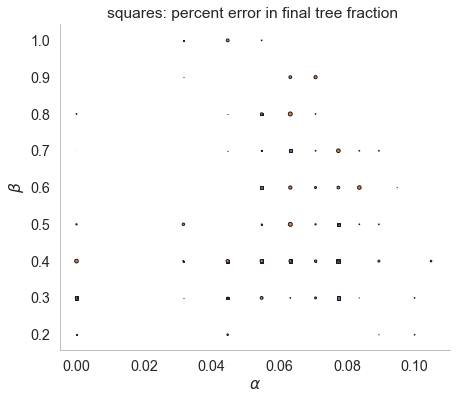

In [286]:


fig, ax = plt.subplots(1,1, figsize = (7, 6), sharex = True)

sub = tabs.query("(abs({0}) < {1})".format(metric, maxerr) )
sub_v = tabs_v.query("(abs({0}) < {1})".format(metric, maxerr))


scale = .5
sizes = (maxerr - np.abs(sub[metric]))*2
plt.scatter(sub.alpha**scale, sub.beta, marker = "s",  
            s = sizes**2, edgecolor = "k")

valid_sizes = (maxerr - np.abs(sub_v[metric]))*2

plt.scatter(sub_v.alpha**scale, sub_v.beta, marker = "o", 
            s = valid_sizes**2,  edgecolor = "k")


ax.set_xlim(-0.005, )

plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\beta$")
plt.title("squares: percent error in final tree fraction "
         );


In [317]:
inds = tabs.query(" abs(tree_final_error) < 3  " ).index
inds_v = tabs_v.query(" abs(tree_final_error) < 3 " ).index

best = tabs.loc[((set(inds) - set(inds_v)))]
best_inds = best[best.bad < 0.35].index

In [318]:
len(best_inds)

12

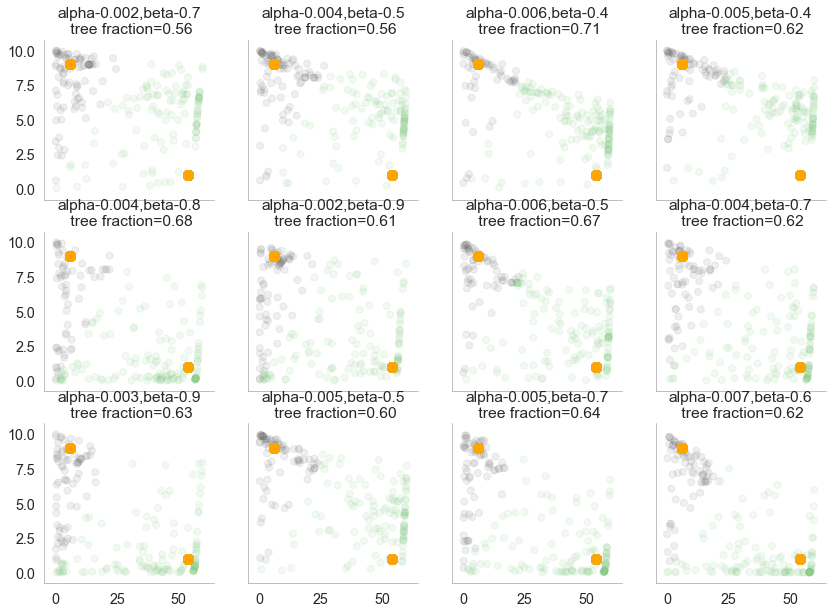

In [319]:
fig, axes = plt.subplots(3, 4,  figsize = (14,10), sharey = True, sharex = True )
axes = axes.ravel()

for i, batch_name in enumerate(best_inds[:12]):
    
    ax = axes[i]
    subset = res[res.batch_name == batch_name].sample(200)
    ax.scatter(subset["G_u"] ,subset["G_l"], c = subset["tree_final"], 
                s= 50, alpha = 0.1, cmap = "Accent_r")
    ax.set_title(batch_name + "\n tree fraction={0:.2f}".format(subset["tree_final"].mean() ))

    ax.scatter(res["G_uo"],res["G_lo"], c = "orange" , s = 100)
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

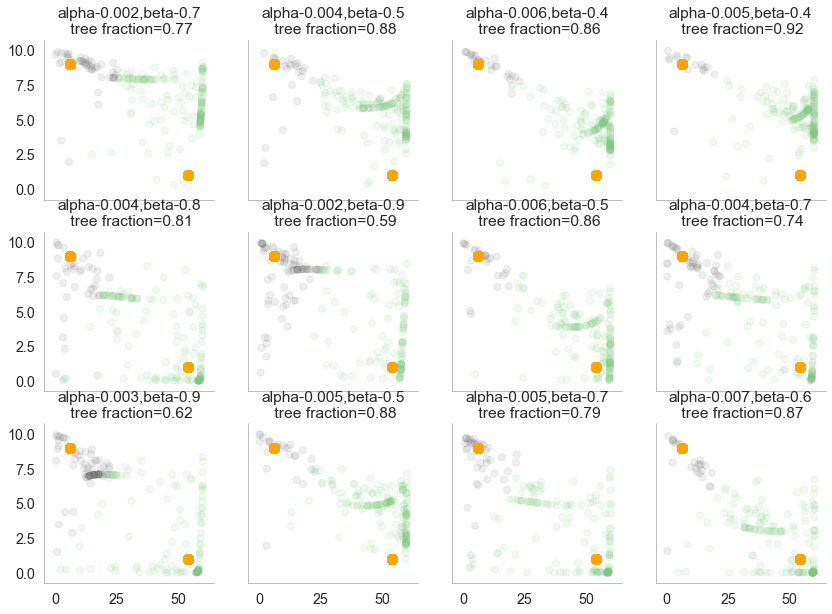

In [320]:
fig, axes = plt.subplots(3, 4,  figsize = (14,10), sharey = True, sharex = True )
axes = axes.ravel()

for i, batch_name in enumerate(best_inds[:12]):
    
    ax = axes[i]
    subset = res_v[res_v.batch_name == batch_name].sample(200)
    ax.scatter(subset["G_u"] ,subset["G_l"], c = subset["tree_final"], 
                s= 50, alpha = 0.1, cmap = "Accent_r")
    ax.set_title(batch_name + "\n tree fraction={0:.2f}".format(subset["tree_final"].mean() ))

    ax.scatter(res_v["G_uo"],res_v["G_lo"], c = "orange" , s = 100)
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [ ]:
len (inds)

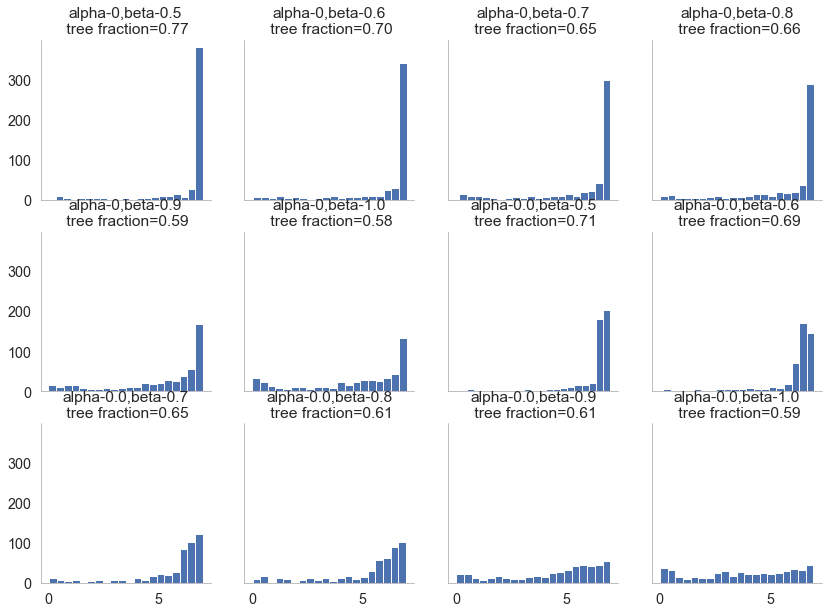

In [131]:
fig, axes = plt.subplots(3, 4,  figsize = (14,10), sharey = True, sharex = True )
axes = axes.ravel()
# inds = tabs[(tabs['tree_final'] > 0.5)&(tabs['tree_final'] < 0.7 )].index

for i, batch_name in enumerate(inds[:12]):
    
    ax = axes[i]
    subset = res[res.batch_name == batch_name].sample(500)
    ax.hist(subset["G_l"] , 20)
    ax.set_title(batch_name + "\n tree fraction={0:.2f}".format(subset["tree_final"].mean() ))

# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

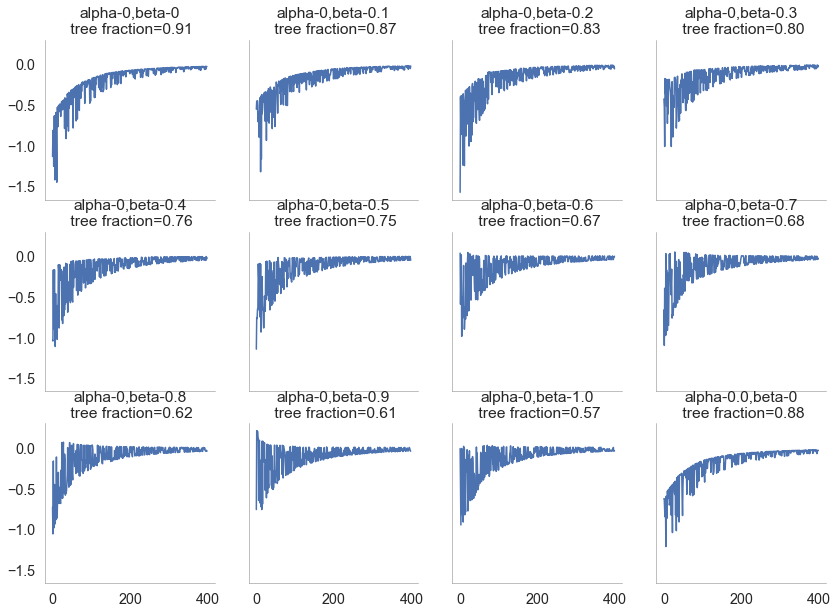

In [83]:
fig, axes = plt.subplots(3, 4,  figsize = (14,10), sharey = True, sharex = True )
axes = axes.ravel()
inds = tabs[(tabs['tree_final'] > 0.5)&(tabs['tree_final'] < 0.7 )].index

for i, batch_name in enumerate(batch_names[:12]):
    
    ax = axes[i]
    subset = res[res.batch_name == batch_name].sample(500)
    conv = np.cumsum(subset["G_u"])/np.cumsum(np.arange(500))
    conv = np.diff(conv)*100
    ax.plot(conv[100:])
#     ax.scatter(subset["G_l"] ,subset["G_u"], c = subset["tree_final"], 
#                 s= 50, alpha = 0.1, cmap = "Accent_r")
    ax.set_title(batch_name + "\n tree fraction={0:.2f}".format(subset["tree_final"].mean() ))

#     ax.scatter(res["G_lo"],res["G_uo"], c = "orange" , s = 100)
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

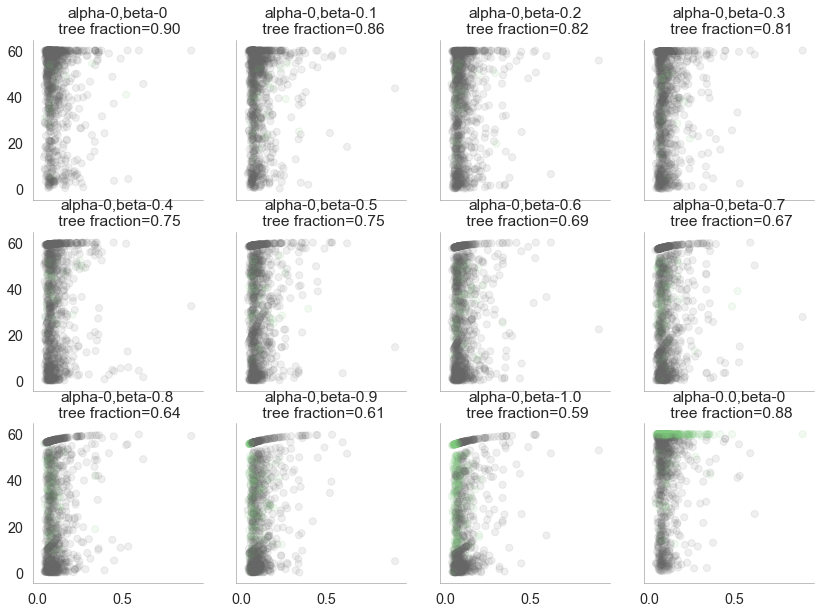

In [84]:
fig, axes = plt.subplots(3, 4,  figsize = (14,10), sharey = True, sharex = True )
axes = axes.ravel()
for i, batch_name in enumerate(batch_names[:12]):
    
    ax = axes[i]
    subset = res[res.batch_name == batch_name]
    ax.scatter(subset["S"] ,subset["G_u"], c = subset["g_u"] > subset["g_l"], 
                s= 50, alpha = 0.1, cmap = "Accent_r")

    ax.set_title(batch_name + "\n tree fraction={0:.2f}".format(subset["tree_final"].mean() ))


Text(0, 0.5, '$G_u$')

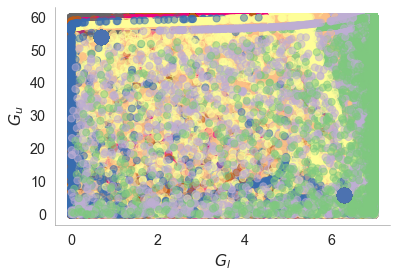

In [85]:
# plt.scatter(res["G_l"] ,res["G_u"], c = res["g_u"] < res["g_l"], s= 50, alpha = 0.1, cmap = "viridis")

plt.scatter(res["G_l"] ,res["G_u"], c = res["c"], s= 50, alpha = 0.5, cmap = "Accent")
plt.scatter(res["G_lo"],res["G_uo"], c = "b" , s = 200)
ax = plt.gca()
ax.set_xlabel("$G_l$")
ax.set_ylabel("$G_u$")